# Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter

**Loading Dataset**

In [2]:
DATASET_DIR = r'D:\cvpr\Dataset'  # Updated path to dataset directory
CATEGORIES = os.listdir(DATASET_DIR)
IMG_SIZE = 32
NUM_IMAGES = 300

In [3]:
all_data = []
for category in CATEGORIES:
    path = os.path.join(DATASET_DIR, category)
    class_index = CATEGORIES.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        all_data.append((img_path, class_index, img_name))

random.shuffle(all_data)
selected_data = all_data[:NUM_IMAGES]

### **Dataset Preprocessing**



In [4]:
features = []
labels = []
display_data = []

for img_path, class_index, img_name in selected_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        features.append(img.flatten() / 255.0)
        labels.append(class_index)
        display_data.append((img, class_index, img_name))
    except:
        continue

features = np.array(features)
labels = np.array(labels)

**Image Visualization**
Display a 30x10 grid of randomly selected images with their filenames.


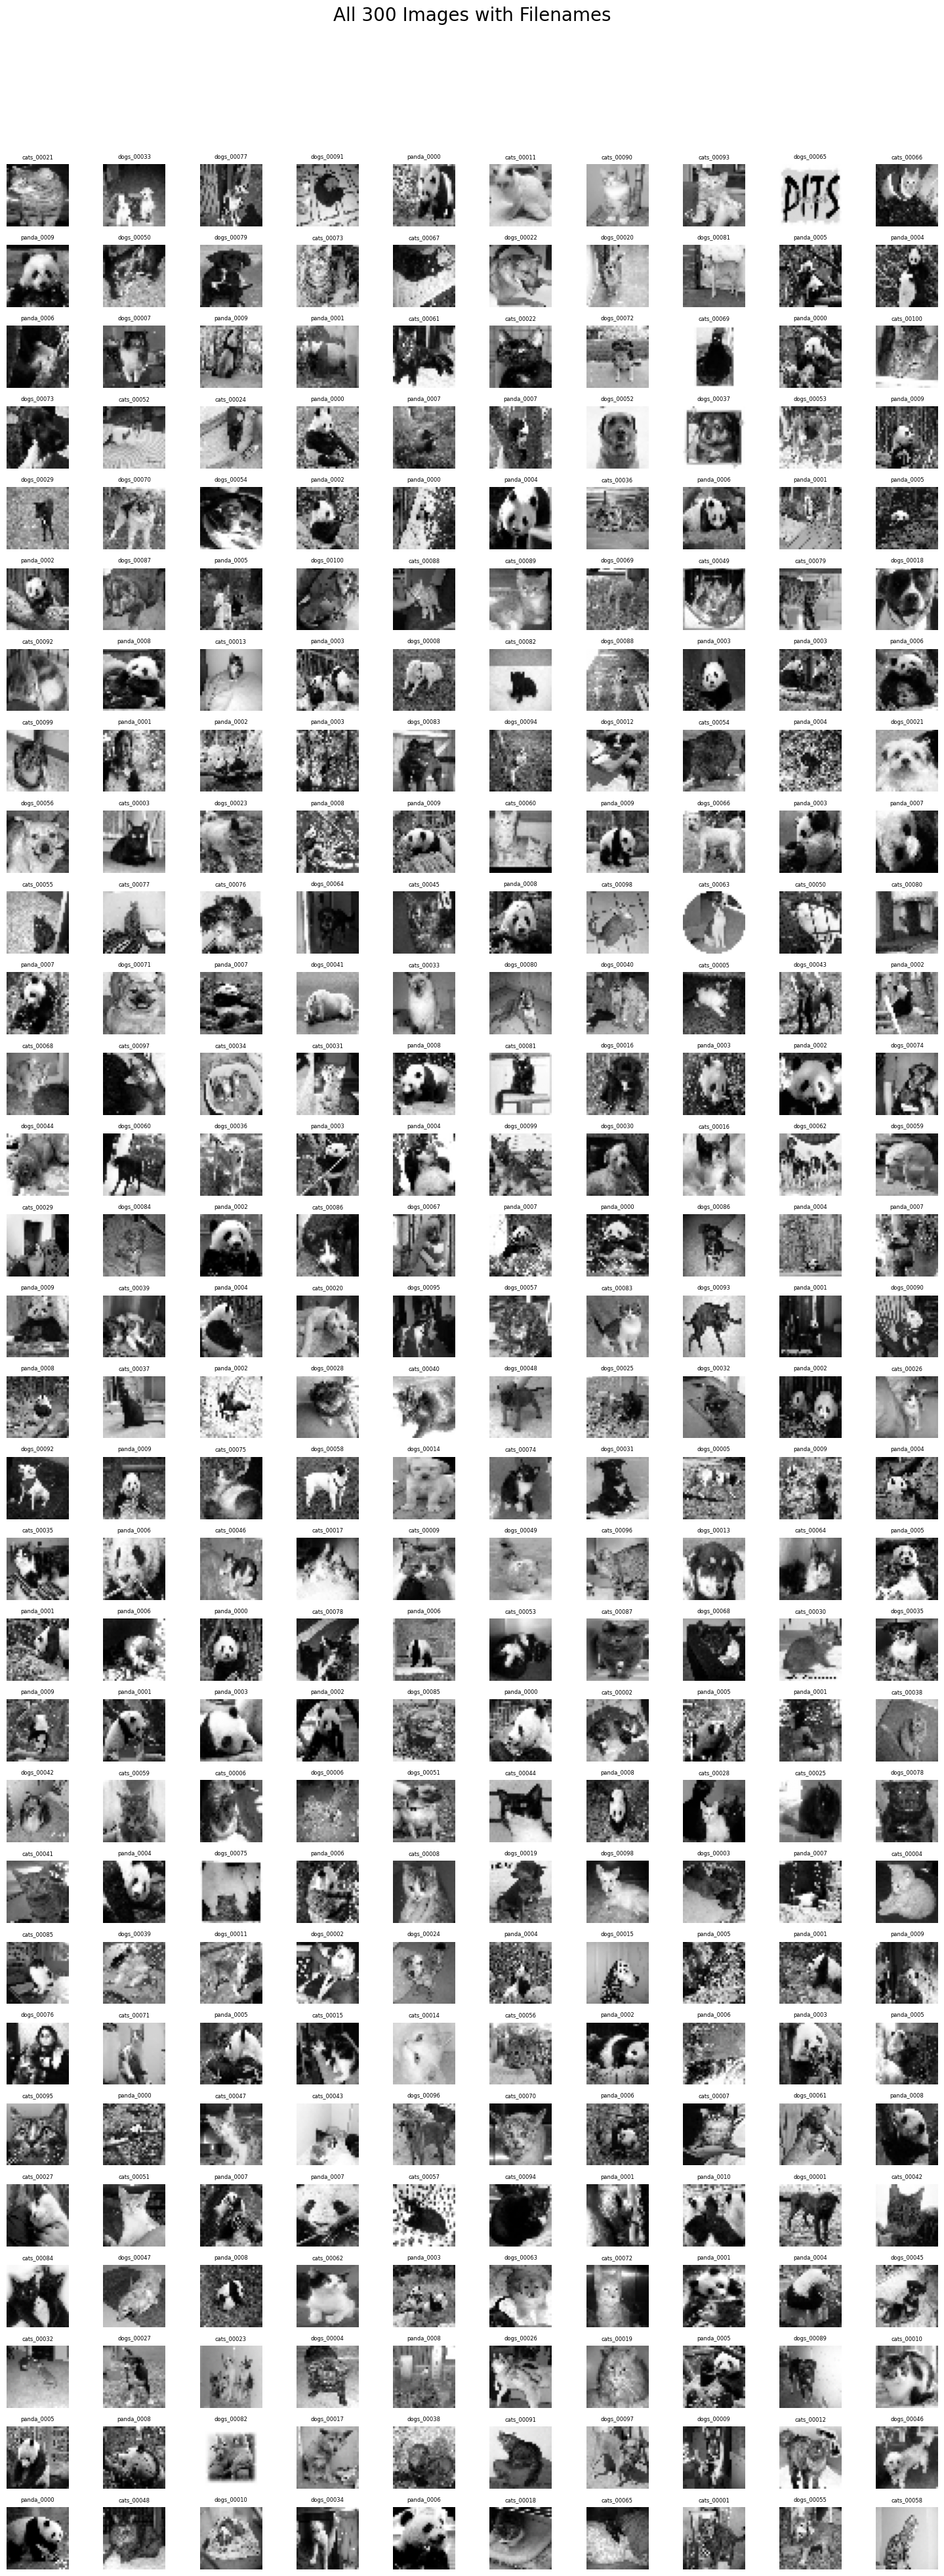

Total images processed: 300


In [5]:
plt.figure(figsize=(15, 40))
for i in range(len(display_data)):
    img, _, name = display_data[i]
    plt.subplot(30,10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(name[:10], fontsize=6)
    plt.axis('off')

plt.suptitle("All 300 Images with Filenames", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("Total images processed:", len(features))

**Manhattan Distance (L1) and Euclidean Distance (L2)**

In [6]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

**5-Fold Preparation**
Shuffle the entire dataset and split it into 5 parts. Handle all leftover samples by distributing them evenly.


In [7]:
#Combine features and labels into data list
data = list(zip(features, labels))

#Shuffle the data
random.shuffle(data)

#Create 5 folds
fold_size = len(data) // 5
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(5)]

#Distribute any remaining items due to rounding
remainder = len(data) % 5
for i in range(remainder):
    folds[i].append(data[5 * fold_size + i])

#Print fold sizes for verification
for i, fold in enumerate(folds):
    print(f"Fold {i+1} size:", len(fold))

Fold 1 size: 60
Fold 2 size: 60
Fold 3 size: 60
Fold 4 size: 60
Fold 5 size: 60


**KNN Prediction**
Implement the k-nearest neighbors logic, where the distances are calculated and majority voting is used to decide the class.


In [8]:
def knn_predict(X_train, y_train, x_test, k=7, distance_type='l2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])

    k_labels = [label for _, label in distances[:k]]

    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]

In [9]:
def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(5):
        validation_data = folds[fold_index]
        training_data = []
        for i in range(5):
            if i != fold_index:
                training_data.extend(folds[i])

        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = (correct / len(X_val)) * 100
            fold_accuracies.append(accuracy)

        fold_wise_accuracies.append(fold_accuracies)

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies

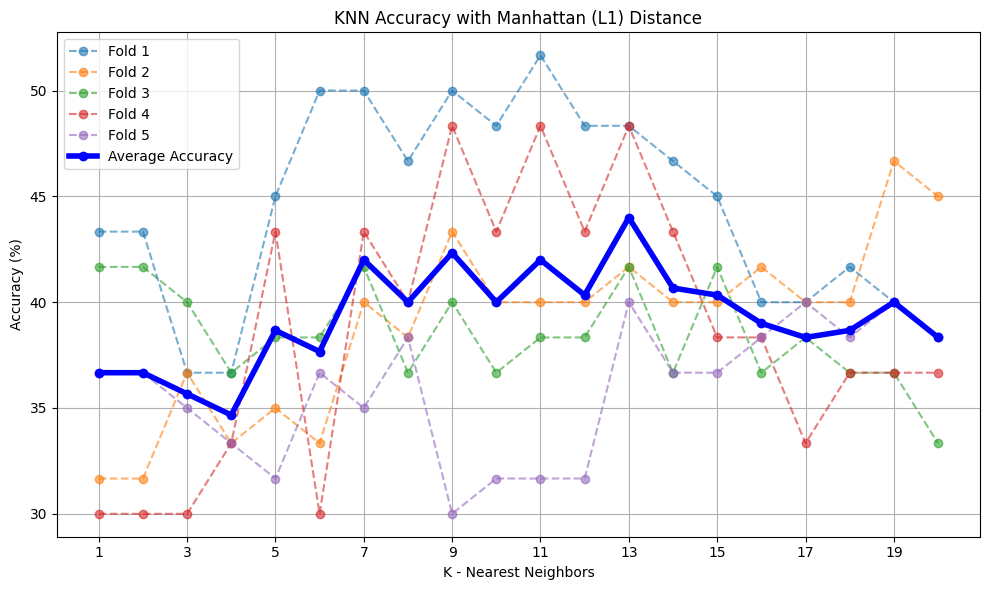

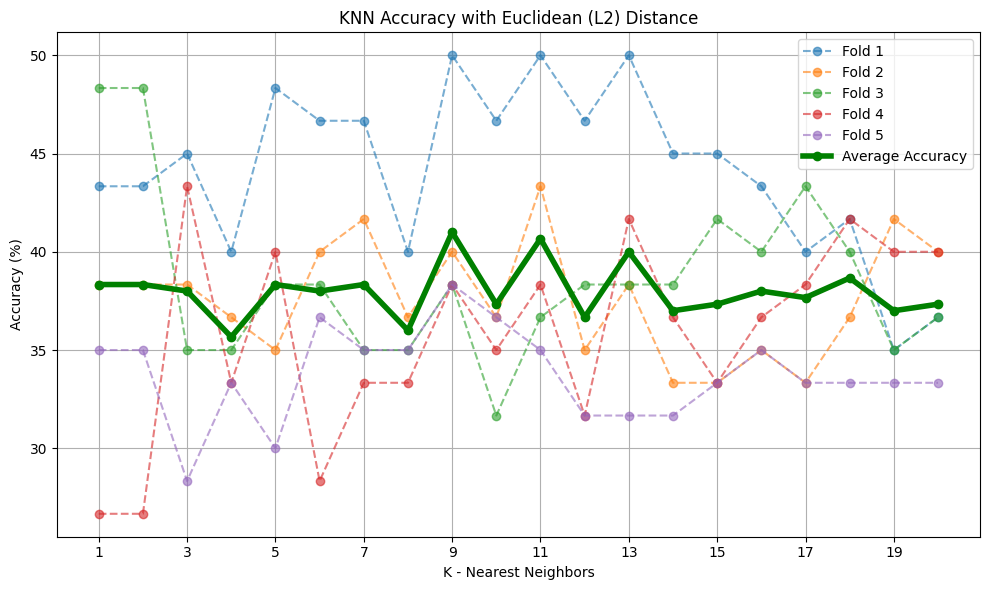

In [10]:
K_values = np.arange(1, 21)

# Run cross-validation for both distances
fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')

# Function to plot fold-wise and average accuracy
def plot_knn_accuracy(K, fold_accuracies, avg_accuracies, title, color):
    plt.figure(figsize=(10, 6))

     # Plot each fold’s accuracy
    for i, acc in enumerate(fold_accuracies):
        plt.plot(K, acc, 'o--', label=f'Fold {i+1}', alpha=0.6)

    # Plot average accuracy
    plt.plot(K, avg_accuracies,'o-', color=color, label='Average Accuracy', linewidth=4)

    plt.xlabel("K - Nearest Neighbors")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 21, 2))
    plt.tight_layout()
    plt.show()

# Plot both distances
plot_knn_accuracy(K_values, fold_acc_l1, avg_acc_l1, "KNN Accuracy with Manhattan (L1) Distance", color='blue')
plot_knn_accuracy(K_values, fold_acc_l2, avg_acc_l2, "KNN Accuracy with Euclidean (L2) Distance", color='green')

**Show average accuracy for both L1 and L2 distance**

In [11]:
print("Average Accuracy for Manhattan (L1) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l1[i]:.2f}%")

print("\nAverage Accuracy for Euclidean (L2) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l2[i]:.2f}%")

Average Accuracy for Manhattan (L1) Distance:
K =  1 : 36.67%
K =  2 : 36.67%
K =  3 : 35.67%
K =  4 : 34.67%
K =  5 : 38.67%
K =  6 : 37.67%
K =  7 : 42.00%
K =  8 : 40.00%
K =  9 : 42.33%
K = 10 : 40.00%
K = 11 : 42.00%
K = 12 : 40.33%
K = 13 : 44.00%
K = 14 : 40.67%
K = 15 : 40.33%
K = 16 : 39.00%
K = 17 : 38.33%
K = 18 : 38.67%
K = 19 : 40.00%
K = 20 : 38.33%

Average Accuracy for Euclidean (L2) Distance:
K =  1 : 38.33%
K =  2 : 38.33%
K =  3 : 38.00%
K =  4 : 35.67%
K =  5 : 38.33%
K =  6 : 38.00%
K =  7 : 38.33%
K =  8 : 36.00%
K =  9 : 41.00%
K = 10 : 37.33%
K = 11 : 40.67%
K = 12 : 36.67%
K = 13 : 40.00%
K = 14 : 37.00%
K = 15 : 37.33%
K = 16 : 38.00%
K = 17 : 37.67%
K = 18 : 38.67%
K = 19 : 37.00%
K = 20 : 37.33%


Shuffle and Split Data

In [12]:
# Create a new list combining features and labels manually
data = []
for i in range(len(features)):
    data.append([features[i], labels[i]])

# Shuffle the combined data
random.shuffle(data)

# Split into 80% training and 20% testing
split = int(0.8 * len(data))
train = data[:split]
test = data[split:]

# Separate features and labels for training
train_x = []
train_y = []
for item in train:
    train_x.append(item[0])
    train_y.append(item[1])

# Separate features and labels for testing
test_x = []
test_y = []
for item in test:
    test_x.append(item[0])
    test_y.append(item[1])

# Convert to numpy arrays
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

 Accuracy Function

In [13]:
def get_accuracy(train_x, train_y, test_x, test_y, k=3, dist_type='l2'):
    correct = 0
    for i in range(len(test_x)):
        pred = knn_predict(train_x, train_y, test_x[i], k=k, distance_type=dist_type)
        if pred == test_y[i]:
            correct += 1
    return (correct / len(test_y)) * 100

Print Training and Testing Accuracy

In [14]:
k = 7  # K-value to test

# L1 Distance (Manhattan)
train_acc_l1 = get_accuracy(train_x, train_y, train_x, train_y, k, 'l1')
test_acc_l1 = get_accuracy(train_x, train_y, test_x, test_y, k, 'l1')

# L2 Distance (Euclidean)
train_acc_l2 = get_accuracy(train_x, train_y, train_x, train_y, k, 'l2')
test_acc_l2 = get_accuracy(train_x, train_y, test_x, test_y, k, 'l2')

# Print results
print(f"L1 - Train Accuracy: {train_acc_l1:.2f}%")
print(f"L1 - Test Accuracy : {test_acc_l1:.2f}%")
print("---")
print(f"L2 - Train Accuracy: {train_acc_l2:.2f}%")
print(f"L2 - Test Accuracy : {test_acc_l2:.2f}%")


L1 - Train Accuracy: 59.58%
L1 - Test Accuracy : 31.67%
---
L2 - Train Accuracy: 59.17%
L2 - Test Accuracy : 26.67%


**Top-5 Predictions Display**
Visually show the first 5 test images along with their predicted and actual labels using both L1 and L2 metrics, side-by-side.


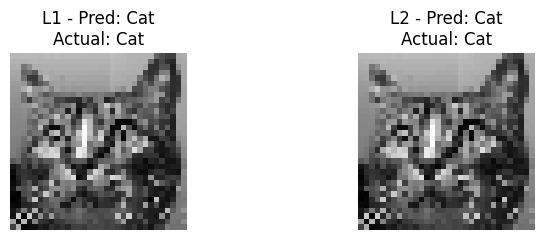

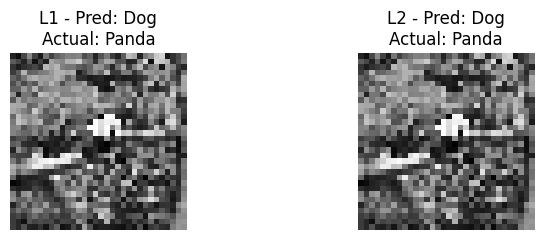

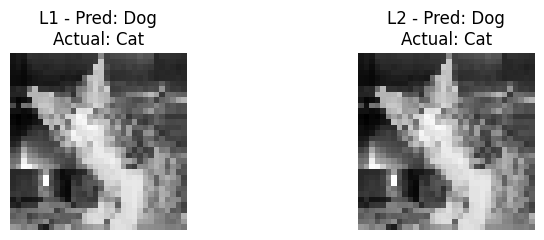

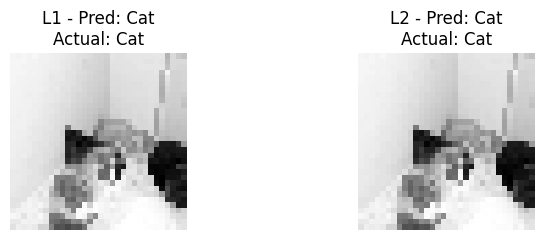

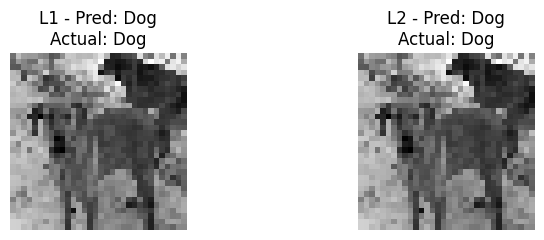

In [15]:
# Step 1: Split data (already done above)
split_index = int(0.8 * len(features))
X_train, X_test = features[:split_index], features[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

# Class names
class_names = ['Cat', 'Dog', 'Panda']

# Step 2: Prediction and visualization for both L1 and L2
def show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7):
    for i in range(5):
        img = X_test[i].reshape(32, 32)

        pred_l1 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l1')
        pred_l2 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l2')

        # Plot side-by-side
        plt.figure(figsize=(8, 2.5))

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"L1 - Pred: {class_names[pred_l1]}\nActual: {class_names[y_test[i]]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img, cmap='gray')
        plt.title(f"L2 - Pred: {class_names[pred_l2]}\nActual: {class_names[y_test[i]]}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call the function
show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7)

Here, we can see the difference of performance of Manhattan Distance(L1) and Euclidean Distance(L2) distances:

L1 - Train Accuracy: 59.58%
L1 - Test Accuracy : 31.67%

L2 - Train Accuracy: 59.17%
L2 - Test Accuracy : 26.67%

It is observed that Manhattan Distance (L1) performed slightly better in both testing and training.